In [2]:
pip install tensorflow==2.11 scikit-learn pandas matplotlib joblib

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\minsu\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.0053 - val_loss: 0.0192
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0191
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0182
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0185
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0172
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0176
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0174
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0171
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0171
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0174
Epoch 11/

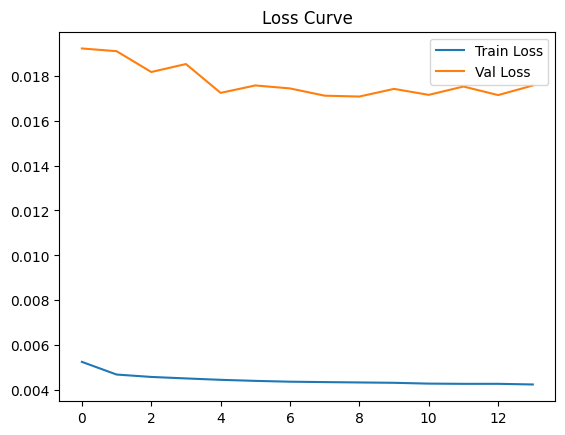

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

# 1. 데이터 로딩
df = pd.read_csv('./제조AI데이터셋_제일전기공업(주).csv', parse_dates=['PROD_DATE'])
df = df.sort_values('PROD_DATE')

# 2. 파생 피처 생성
df['dayofweek'] = df['PROD_DATE'].dt.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df_filtered = df[['PROD_QTY', 'SALE_QTY', 'BASE_DAY', 'BASE_MON', 'dayofweek', 'is_weekend']].dropna()

# 3. 스케일링
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_filtered)
joblib.dump(scaler, './scaler_3in_7out.save')

# 4. 시퀀스 생성 함수
def create_sequence_multistep(dataset, input_len=3, output_len=7):
    X, y = [], []
    for i in range(len(dataset) - input_len - output_len):
        X.append(dataset[i:i+input_len])
        y.append(dataset[i+input_len:i+input_len+output_len, 0])  # 0 = PROD_QTY
    return np.array(X), np.array(y)

X, y = create_sequence_multistep(scaled, 3, 7)

# 5. 학습/검증 분할
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# 6. 모델 정의 (Functional API)
inputs = Input(shape=(3, X.shape[2]))
x = LSTM(64, activation='relu')(inputs)
outputs = Dense(7)(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

# 7. 학습
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

# 8. 저장
model.save('./lstm_3in_7out_model.keras')
print("✅ 모델과 스케일러 저장 완료")

# 9. 학습곡선 출력
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()
